## Fine tune sentence transformer model for text similarity

### Goal
- Build evaluation pipeline
- Evaluate the existing model
- Fine tune the model
- Evaluate the fine tuned model
- Compare the results

### Install dependencies


In [ ]:
%pip install sentence-transformers matplotlib

### Download and Prepare the Dataset 

In [4]:
from datasets import load_dataset

ds = load_dataset("JianLiao/spectrum-design-docs", split="train")

queries = {}
corpus = {}
relevant_docs = {}

for idx, row in enumerate(ds):
    # Setup unique query_id and doc_id
    query_id = f"q{idx+1}"
    doc_id = f"d{idx+1}"
    
    # Populate dictionaries
    # queries[query_id] = f"Represent this sentence for searching relevant passages: {row["anchor"]}"
    queries[query_id] = row["anchor"]
    corpus[doc_id] = row["positive"]
    # print(f"Query: {queries[query_id]}")
    # print(f"Document: {corpus[doc_id]}")
    
    # Only one relevant document per query
    relevant_docs[query_id] = {doc_id} # Change to [] if multiple relevant documents

### Evaluate Using InformationRetrievalEvaluator

In [5]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import InformationRetrievalEvaluator, SequentialEvaluator
from sentence_transformers.util import cos_sim

# Load the model
embedding_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

# EMBEDDING_DIMS = [384, 512, 640, 768, 896, 1024, 1152, 1280]
EMBEDDING_DIMS = [512, 768, 1024]

matryoshka_evaluators = []

for dim in EMBEDDING_DIMS:
    ir_evaluator = InformationRetrievalEvaluator(
        queries=queries,
        corpus=corpus,
        relevant_docs=relevant_docs,
        name=f"sds-docs-{dim}",
        truncate_dim=dim,
        score_functions={"cosine": cos_sim},
    )
    matryoshka_evaluators.append(ir_evaluator)

# Create a sequential evaluator
evaluator = SequentialEvaluator(matryoshka_evaluators)

results = evaluator(model=embedding_model)

### Show the Results

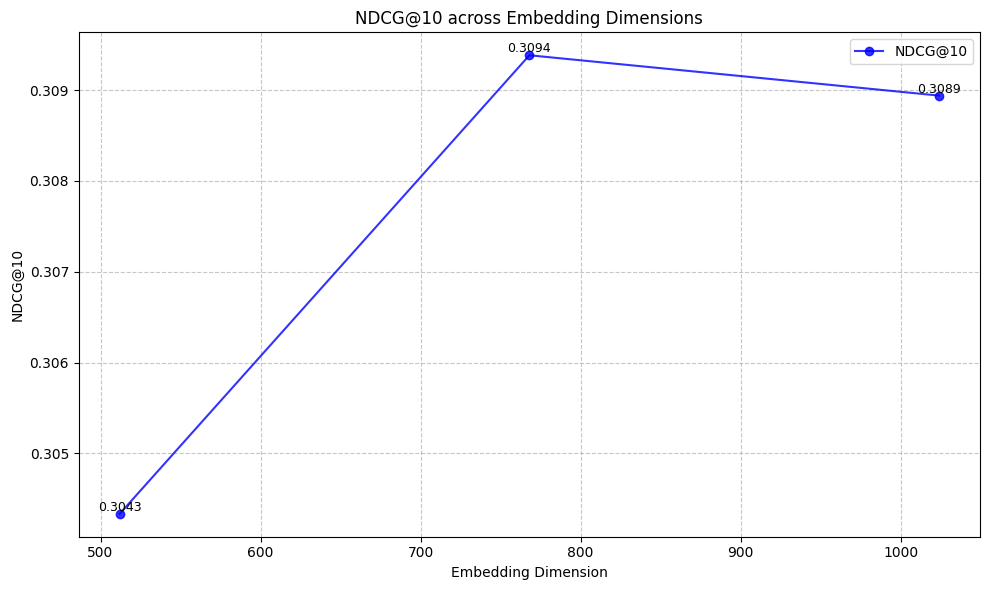

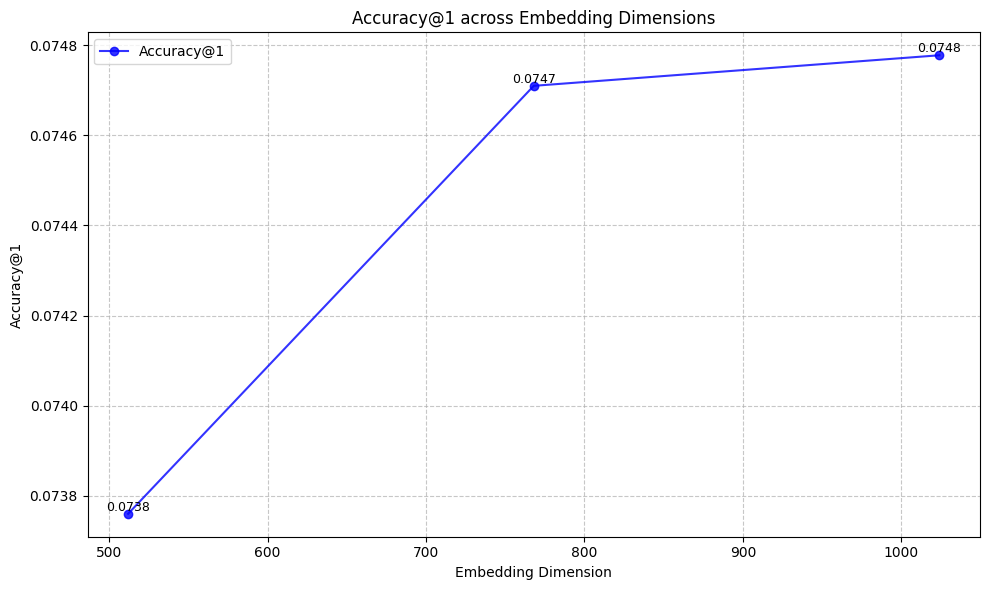

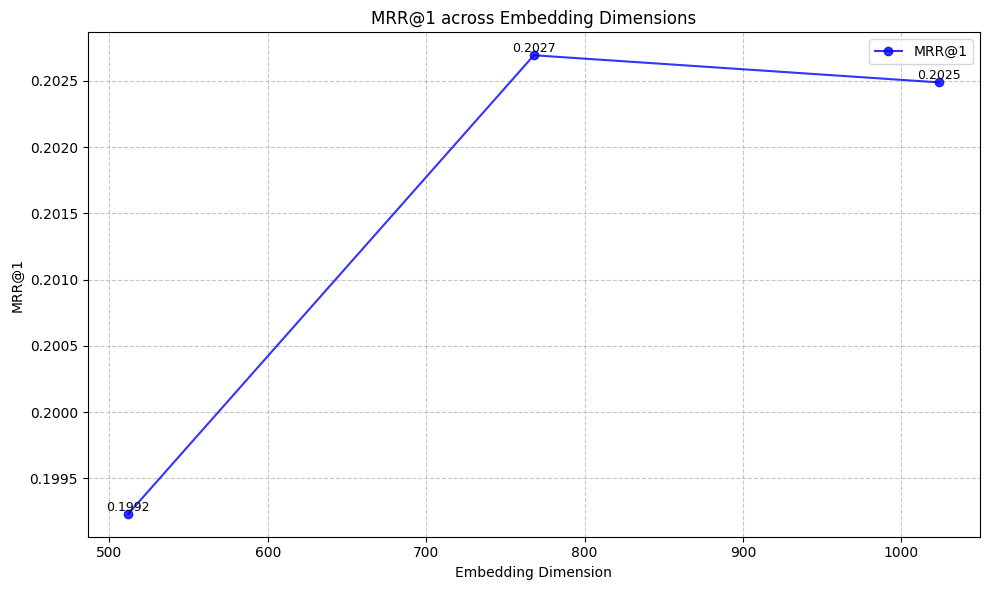

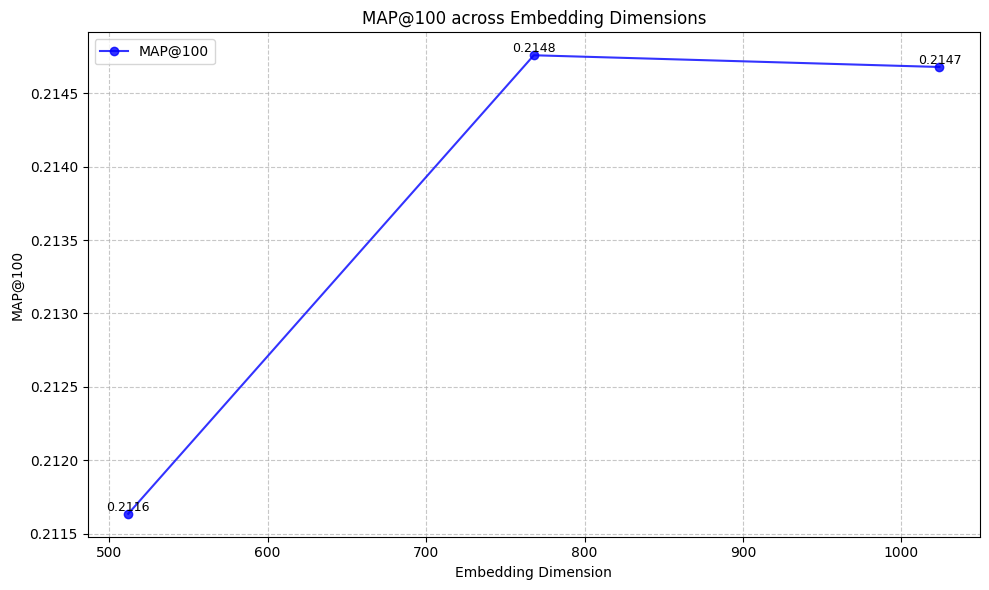

In [6]:
import matplotlib.pyplot as plt

def visualize_metrics_line(embedding_dims, metrics_dict):
    """
    Visualizes metrics across embedding dimensions as line charts.
    
    Args:
        embedding_dims (list): List of embedding dimensions.
        metrics_dict (dict): Dictionary with metric names as keys and lists of corresponding values as values.
                             Example: {"NDCG@10": [0.3, 0.4, 0.5], "Accuracy@1": [0.1, 0.2, 0.3]}
    """
    for metric_name, metric_values in metrics_dict.items():
        plt.figure(figsize=(10, 6))
        plt.plot(embedding_dims, metric_values, marker='o', label=metric_name, color='blue', alpha=0.8)
        
        # Annotate each point with the actual value
        for i, value in enumerate(metric_values):
            plt.text(embedding_dims[i], value, f"{value:.4f}", fontsize=9, ha='center', va='bottom')
        
        plt.title(f'{metric_name} across Embedding Dimensions')
        plt.xlabel('Embedding Dimension')
        plt.ylabel(metric_name)
        plt.grid(axis='both', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.legend()
        plt.show()


metrics = {
    "NDCG@10": [results[f"sds-docs-{dim}_cosine_ndcg@10"] for dim in EMBEDDING_DIMS],
    "Accuracy@1": [results[f"sds-docs-{dim}_cosine_accuracy@1"] for dim in EMBEDDING_DIMS],
    "MRR@1": [results[f"sds-docs-{dim}_cosine_mrr@10"] for dim in EMBEDDING_DIMS],
    "MAP@100": [results[f"sds-docs-{dim}_cosine_map@100"] for dim in EMBEDDING_DIMS]
}

visualize_metrics_line(EMBEDDING_DIMS, metrics)